<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Redes neuronales recurrentes con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales recurrentes para la detección, clasificación y localización de errores en datos temporales producidos por varios sensores. 

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales. Los datos deberán ser descargados desde este google drive:

[<h3><center>datos</center></h3>](https://drive.google.com/drive/folders/1n-kWjxRXXd4_vRPuctFH6qQVll7kcyUH?usp=share_link)

y los guardaremos en una carpeta `/data` que estará en la carpeta raíz con el notebook. Los datos constan de la lectura de 3 sensores de monitorización.

Estos sensores no son perfectos y sistemáticamente producen lecturas erróneas. Además, están situados en un laboratorio en la novena planta de un edificio que se encuentra sobre las vías del metro, y al pasar éste por debajo deja un rastro en las lecturas de los sensores.

Nuestra tarea final es la clasificación y localización de estos defectos. Para ello, la PEC consta de varias etapas:

*   Interpretanción de los datos disponibles.
*   Creación de un modelo de clasificación basado en una RNN. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca. 
*   Una vez tengamos clasificados los errores los tendremos que localizar a lo largo de la sequencia temporal y para ello deberemos volver a entrenar otro modelo basado en el modelo de clasificación.
*   El producto final será una función que dada una señal de los sensores, devolverá el tipo de error, la localización de éste y un plot señalando el error.

**NOTA: se recomienda usar GPU para los entrenamientos, pero recordar las limitación de uso de GPU. Hacer los primeros test sin GPU o con muy pocos datos.**

In [1]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model

In [2]:
#------------------------------#
#       SI USASMOS COLAB       #
#------------------------------#

from google.colab import drive
drive.mount('/content/drive')
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Descarga, análisis y pre-procesado de los datos (2 puntos)

## 1.1 Importación

Primero importamos los datos desde los ficheros `xl.pickle` y  `yl.pickle`.

In [3]:
home =  './drive/MyDrive/UOC/Deep_Learning/'

with open(home+"data/xl.pickle", "rb") as f:
    xl = pickle.load(f)
with open(home+"data/yl.pickle", "rb") as f:
    yl = pickle.load(f)

## 1.2 Plots

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Elige aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>
</div>

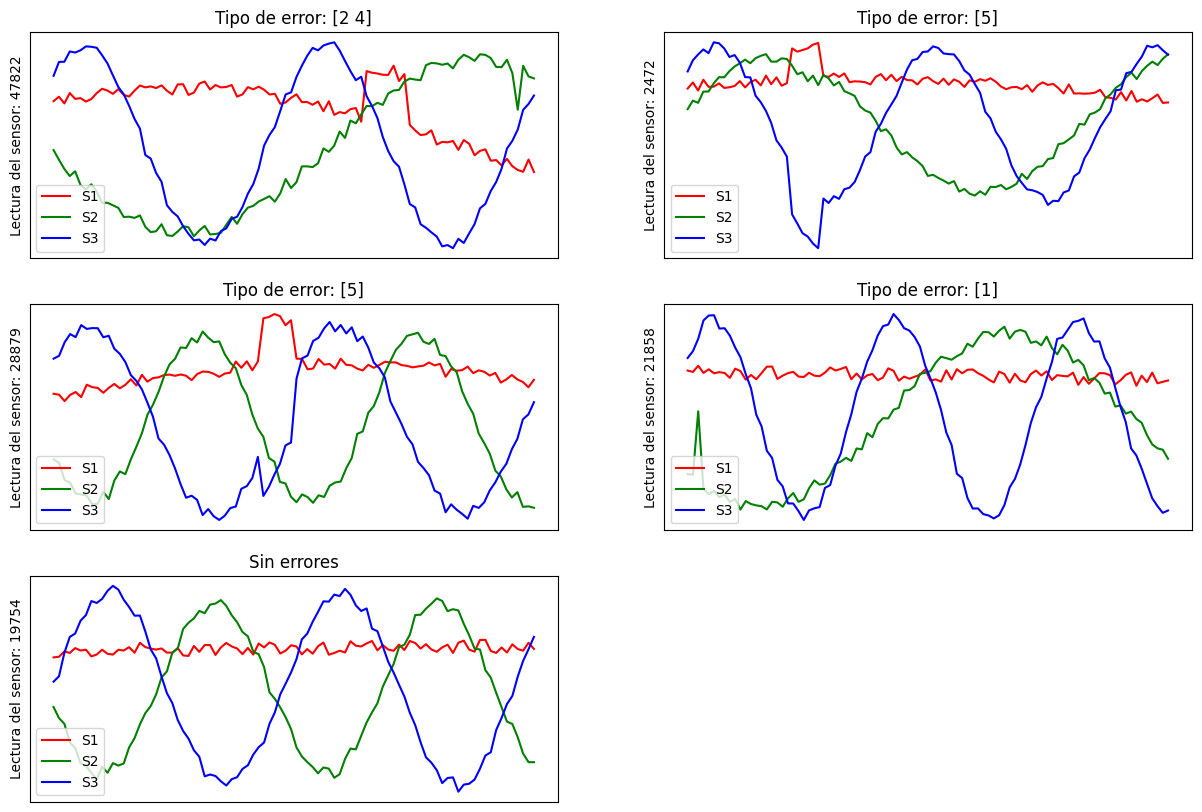

In [ ]:
import random

def sensor_plotter(indices, titles=None):
    plt.figure(figsize=(15,10))
    for pos,i in enumerate(indices):        
        plt.subplot(3,2,pos+1)
        lectura = xl[i]
        # Denomino los sensores según su posición en el array
        plt.plot(lectura[:,0], color='r', label='S1')
        plt.plot(lectura[:,1], color='g', label='S2')
        plt.plot(lectura[:,2], color='b', label='S3')
        plt.legend(loc='lower left')
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(f'Lectura del sensor: {i+1}')
        # Añadimos +1 para crear el rango [1,5] de errores
        errors = np.where(yl[i])[0] + 1
        output = "Tipo de error: " + str(errors) if len(errors)>0 else "Sin errores"
        plt.title(f'{output}')
        if titles:
            plt.xlabel(titles[pos])
    plt.show()
sensor_plotter(random.sample(range(len(xl)), 5))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Describe los datos</strong>: tipo de funciones, diferentes tipos de errores que puedas identificar, etc...</p>
Los sensores suelen capturar datos de manera senoidal, y cada uno presenta ciertas características propias. Por ejemplo, el sensor 1 suele tener una curva más plana, mientras que los sensores 2 y 3 presenta una curva más ancha y estrecha.
<br><br>
Para evitar errores, es importante que la captura de datos sea continua y constante, sin presentar picos.
<br><br>
El error de <b>Tipo 1 parece fácil de detectar, ya que a menudo se caracteriza por un pico elevado de corta duración</b>.
<br><br>
El error de <b>Tipo 5 parece afectar a varios sensores simultaneamente</b>.
</div>

## 1.3 Estadísticos sobre los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Realiza un estudio estadístico básico de los datos:</p>
  <ul>
    <li> Convierte los labels booleanos en numéricos <code>False -> 0.</code> y <code>True -> 1.</code>. </li>
    <li>Probabilidad de aparición de cada tipo de error. Haz un histograma para la clase con menor probabilidad de aparición.</li>
    <li>Longitud media, máxima y mínima de las lecturas de los sensores. Haz un histograma para las longitudes y determina que tipo de distribución genera las diferentes logitudes en las lecturas de los sensores.</li>
  </ul>
</div>

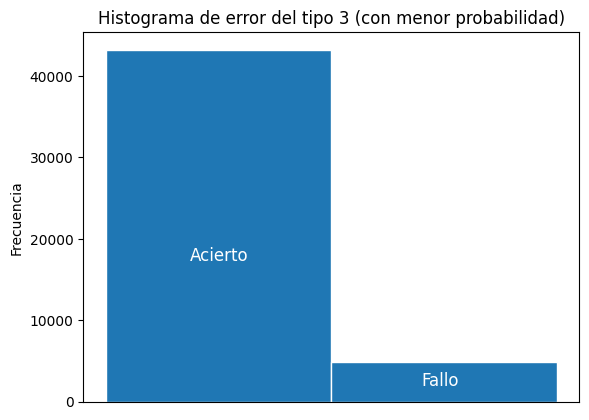

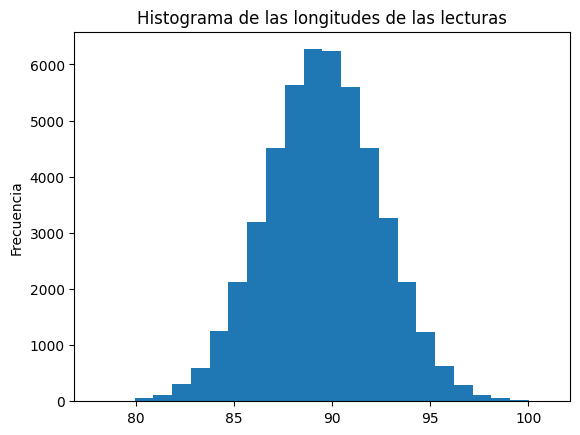

Longitud media: 89.50289665483088
Longitud máxima: 101
Longitud mínima: 78


In [6]:
# Convertimos los labels booleanos a numéricos
yl_numeric = np.array(yl).astype(bool).astype(int)

# Calculamos la probabilidad de cada tipo de error
prob_error = yl_numeric.mean(axis=0)
# Histograma para el de menor probabilidad
index_min_prob_error = prob_error.argmin()
plt.figure()
_, bins, _ = plt.hist(yl_numeric[:, index_min_prob_error], bins=2, edgecolor='w')
# Ploteo el texto sobre el bin de Acierto o Fallo
plt.text((bins[1]/2)*0.75, sum(yl_numeric[:, index_min_prob_error] == 0)*0.4, 'Acierto', fontsize=12, color='white')
plt.text((bins[1]+bins[1])*0.7, sum(yl_numeric[:, index_min_prob_error] == 1)*0.4, 'Fallo', fontsize=12, color='white')
plt.title(f'Histograma de error del tipo {index_min_prob_error+1} (con menor probabilidad)')
plt.ylabel('Frecuencia')
plt.xticks([])
plt.show()

# Longitud media, máxima y mínima de las lecturas de los sensores.
longitudes = [len(l) for l in xl]
longitudes_media = np.mean(longitudes)
longitudes_max = np.max(longitudes)
longitudes_min = np.min(longitudes)
# Histograma para las longitudes
plt.figure()
plt.hist(longitudes,bins=len(set(longitudes)))
plt.title('Histograma de las longitudes de las lecturas')
plt.ylabel('Frecuencia')
plt.show()
print('Longitud media:', longitudes_media)
print('Longitud máxima:', longitudes_max)
print('Longitud mínima:', longitudes_min)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
Se observa que la distribución de los valores de longitud siguen <b>una distribución normal</b>, lo cual es de esperar dada la gran cantidad de datos que se tiene (48159). Los valores se concentran en torno a la media y la desviación estándar es pequeña.
<br><br>
Respecto a los diferentes tipos de errores, observamos que el error menos probable (Tipo 3) presentó una tasa de ocurrencia del 10%, mientras que el error más común (Tipo 5) tuvo una tasa del 46%, siendo este último considerablemente más probable.
</div>

## 1.4 Uniformizando la longitud de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Dado que las lecturas de los sensores tiene longitudes variables, necesitamos estandarizarlas. Para esta sección, hay varias opciones pero empezaremos por la más sencilla:</p>
  <ul>
    <li>Las lecturas con tiempos mayores a la media, las cortaremos.</li>
    <li>Las lecturas con tiempos menores a las medias, las completaremos con el valor médio de cada sensor.</li>
  </ul>
<p>Después de este proceso, elige un caso de tiempo mayor y uno menor y visualizalos usando la función <code>sensor_plotter</code>.</p>
</div>

In [7]:
# Redondeamos a 90 para facilitar separaciones
round_long_media = round(longitudes_media)
for i in range(len(xl)):
    longitud_lect = len(xl[i])
    
    # Lectura con tiempo mayor
    if longitud_lect > round_long_media:
        xl[i] = xl[i][:round_long_media]
        tiempo_mayor = i

    # Lectura con tiempo menor
    elif longitud_lect < round_long_media:
        xl[i] = np.concatenate((xl[i],np.tile(np.mean(xl[i], axis=0), (round_long_media-longitud_lect,1))), axis=0)
        tiempo_menor = i

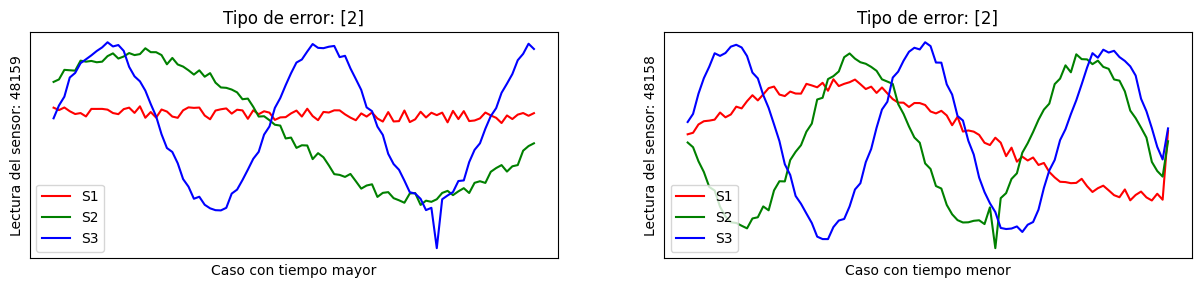

In [ ]:
# Visualización
sensor_plotter([tiempo_mayor, tiempo_menor], titles=["Caso con tiempo mayor", "Caso con tiempo menor"])

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta que tipo de problemas puede conllevar este proceso</strong>. ¿Propondrías otro método para uniformizar los datos?</p>

La estandarización de las lecturas realizada conlleva sus problemas. Por un lado, al cortar la información que sobrepasa la longitud media de lectura, en los casos de tiempo mayor, perdemos información valiosa. Por otro lado, al utilizar la media para rellenar los valores que tienen una longitud de lectura menor que la media, podemos observar en la gráfica cómo los valores medios generan picos en las ondas sinoidales, lo que puede causar confusión, ya que los picos son signos de errores.<br><br>
Considero que un método más apropiado para uniformizar los datos es <b>la interpolación</b>. En lugar de basarnos en un valor medio que depende de toda la lectura, podemos utilizar valores cercanos para determinar el valor faltante. De esta forma, podríamos interpolar en los puntos donde la pendiente es cercana a cero, lo que significa que estamos en un punto de la curva en el que agregar un dato sería menos perjudicial (menos notable) para el conjunto de datos.<br><br>
En el caso de las lecturas con longitud menor a la media, buscaría las pendientes de la curva cercanas a cero y agregaría un dato interpolado en función de la media de sus dos vecinos más cercanos y, en lugar de rellenar hasta la media, podría rellenar hasta la longitud máxima de todas las lecturas si no altera demasiado el conjunto de datos.<br><br>
En cuanto a la longitud máxima, podríamos eliminar los valores en los que la pendiente es cercana a cero, ya que esta parte de la curva nos proporciona la menor cantidad de información.
</div>

In [ ]:
# Indica las dimensiones de los datos y los labels
print(f"Dimensiones de los datos: ({len(xl)}, {xl[0].shape})")
print(f"Dimensiones de los labels : ({len(yl)}, {yl[0].shape})")

Dimensiones de los datos: (48159, (90, 3))
Dimensiones de los labels : (48159, (5,))


## 1.5 Data split para clasificación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Antes de empezar con la construcción de un modelo de clasificación, realizaremos una partición (split) de los datos en 3 grupos:</p>
  <ul>
    <li> 80% para entrenamiento: <code>x_train</code></li>
    <li> 10% para validacion: <code>x_val</code></li>
    <li> 10% para testeo <code>x_test</code></li>
  </ul>
<p>y un <i>shuffle</i> de cada conjunto.</p>
</div>

In [8]:
from random import shuffle

# Buscamos índices 80/10/10
train_idx = int(0.8 * len(xl))
val_idx = int(0.9 * len(xl))

# Creamos particiones
train_data = list(zip(xl[:train_idx], yl_numeric[:train_idx]))
val_data = list(zip(xl[train_idx:val_idx], yl_numeric[train_idx:val_idx]))
test_data = list(zip(xl[val_idx:], yl_numeric[val_idx:]))

# Mezclamos los datos
shuffle(train_data)
shuffle(val_data)
shuffle(test_data)

# Separamos datos y etiquetas
x_train, y_train = zip(*train_data)
x_val, y_val = zip(*val_data)
x_test, y_test = zip(*test_data)

# Convertimos en array
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

# 2. Clasificación (3 puntos)

El primer paso será definir las dimensiones de los datos de entrada en los modelos

In [9]:
# Definimos el número de sensores de los que disponemos y el número de clases (tipos de errores)
num_sensores = 3
num_clases = 5

## 2.1 Callbacks

Una vez tenemos los datos preparados y entendemos mejor el conjunto de datos del que disponemos, podemos empezar a testear diferentes arquitecturas para la clasificación de los tipos de errores. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Primero, crearemos un callback propio para conocer el tiempo utilizado en el entrenamiento ya que lo usaremos también como métrica a la hora de escoger la arquitectura final de la red de clasificación.</p>
</div>

In [10]:
class TimerCallback(Callback):
    # Inicializamos la clase
    def __init__(self):
        self.start_time = None
        self.epoch_times = []
        
    # Inicializamos el timer
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    
    # Guardamos la duración de la epoch y reseteamos el timer
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = timer() - self.start_time
        self.start_time = timer()
        self.epoch_times.append(epoch_time)

Además, usaremos la siguiente clase para visualizar las métricas durante el _fit_ de los modelos:

In [11]:
#------------------------------#
#     NO TOCAR ESTA CLASE      #
#------------------------------#

class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
        self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
            metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
            ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
            try:
                ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
            except:
                pass
            ax.set_xlabel('# epochs')
            ax.set_ylabel(metric[i])
            ax.legend()
            ax.grid()

        plt.tight_layout()
        plt.show()

## 2.2 SimpleRNN Layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El primer paso será construir un modelo, <code>simpleRNN_model</code>, basado en un único _layer_ <code>SimpleRNN</code> para tener un primer modelo base con el que comparar:</p>
  <ul>
    <li><code>SimpleRNN</code> con <code>units = 128</code>.</li>
    <li>La capa final será una cada densa con tantos nodos como clases tenemos.</li>
  </ul>
<p>El output de la capa densa la interpretaremos como una probabilidad, por lo que es necesario escoger correctamente la función de activación y justificar su elección. Además, utilizaremos <code>Adam</code> como optimizador y la función de <i>loss</i> deberá ser la adecuada teniendo en cuenta la tarea que llevamos a cabo.</p>
</div>

**NOTA**: 
- Se recomienda, al final de la creación de cada modelo, utilizar la función `summary()` para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.

In [ ]:
# Utilizamos la función de activación Sigmoid porque nuestro objetivo es predecir la probabilidad de cada clase individualmente
# Si usáramos la función de activación softmax, la suma de las probabilidades es 1 (excluye múltiples errores)
simpleRNN_model = Sequential([
    SimpleRNN(units=128, input_shape=(None,num_sensores)),
    Dense(num_clases, activation='sigmoid')
])
# Usamos la función de loss binary accuracy porque calcula la precisión conjunta de cada tipo de error
simpleRNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
simpleRNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16896     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  Entrenaremos por 100 epochs con <code>batch_size = 256</code> y usando los siguientes callbacks:</p>
  <ul>
    <li>  TimerCallback (ver apartado 2.1)</li>
    <li>  PlotLearning (ver apartado 2.1)</li>
    <li>  EarlyStopping con una persistencia de 5 epochs</li>
    <li>  ReduceLROnPlateau con una persistencia de 5 epochs y monitorizando la <code>loss</code></li>
  </ul>
<p>Al finalizar el entreamiento:</p>
<ul>
    <li>  Realizar la evaluación del modelo y mostrar la <code>loss</code> y la <code>accuracy</code> final sobre los datos de test.</li>
    <li>  Realiza un plot del tiempo para cada epoch y calcula el tiempo total de entrenamiento con la información almacenada en el <code>TimerCallback</code> que has definido. </li>
  </ul>
</div>

**NOTAS**: 
- Se recomienda hacer una función que imprima esta gráfica para poder reutilizarla en próximos apartados.
- Se recomienda SIEMPRE guardar los modelos una vez entrenados, pero es muy importante si trabajáis con entornos como Colab que os cierra las sesiones.
- Los timepos los necesitaremos luego, por lo que puede ser una buena idea también guardar los resultados de tiempos para cada epoch.

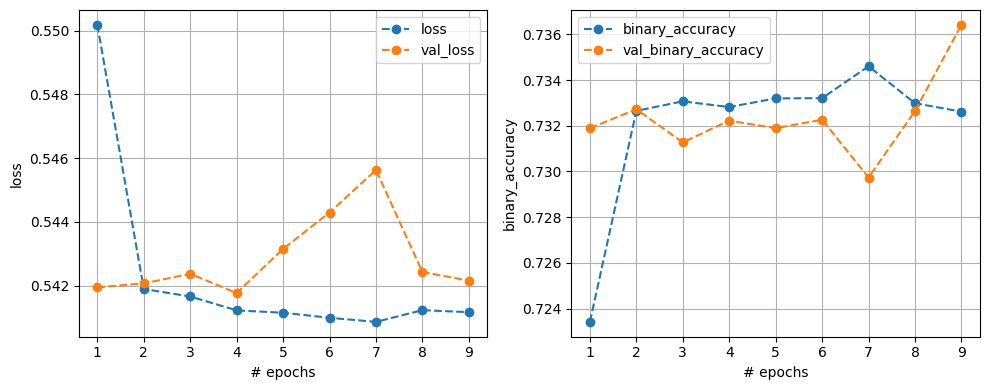

151/151 [==============================] - 1s 9ms/step - loss: 0.5394 - binary_accuracy: 0.7317
Loss en test: 0.5393857955932617
Accuracy en test: 0.7317277789115906


In [ ]:
# Definición de callbacks
timer_rnn = TimerCallback()
plotting_rnn = PlotLearning()
early_stopping_rnn = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_rnn = ReduceLROnPlateau(patience=5, monitor='val_loss')

# Entrenamiento del modelo
history_rnn = simpleRNN_model.fit(x_train, y_train, 
                              batch_size=256, 
                              epochs=100, 
                              validation_data=(x_val, y_val), 
                              callbacks=[timer_rnn, plotting_rnn, early_stopping_rnn, reduce_lr_rnn])

# Evaluación de modelo
loss_rnn, acc_rnn = simpleRNN_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_rnn}")
print(f"Accuracy en test: {acc_rnn}")

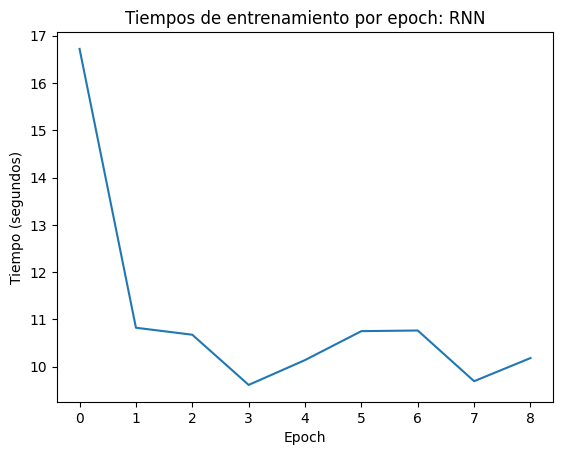

Tiempo total de entrenamiento: 99.37592778700002 segundos
Tiempo medio de epoch: 11.041769754111113 segundos


In [ ]:
def tiempo_entrenamiento(model, timer):    
    # Realizamos un plot del tiempo para cada epoch
    plt.plot(timer.epoch_times)
    plt.title('Tiempos de entrenamiento por epoch: ' + model)
    plt.xlabel('Epoch')
    plt.ylabel('Tiempo (segundos)')
    plt.show()
    
    # Calculamos el tiempo total de entrenamiento
    total_time = sum(timer.epoch_times)
    print(f"Tiempo total de entrenamiento: {total_time} segundos")
    print(f"Tiempo medio de epoch: {total_time/len(timer.epoch_times)} segundos")
    
tiempo_entrenamiento("RNN", timer_rnn)

In [ ]:
# Guardo el modelo y los tiempos de cada epoch
simpleRNN_model.save(home+'modelo_rnn.h5')
with open(home+'times_epoch_rnn.pkl', 'wb') as f:
    pickle.dump(timer_rnn.epoch_times, f)

## 2.3 GRU layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  En este apartado replicaremos el modelo anterior, pero ahora cambiando el layer <code>SimpleRNN</code> por un layer <code>GRU</code> para comparar el rendimiento y el tiempo de entrenamiento. En este caso utilizaremos 64 unidades en lugar de 128 para mantener el número de parámetros y el tiempo de entrenamiento bajos.</p>
<p>Comenta los resultados:</p>
<ul>
    <li>  ¿Mejora el rendimiento general?</li>
    <li>  ¿Aumenta el tiempo de entrenamiento? ¿Y el número de parámetros entrenables?</li>
    <li>  ¿Cúal funciona mejor? ¿Por qué crees que sucede esto?</li>
  </ul>
</div>

In [ ]:
# Modelo con una capa GRU
gru_model = Sequential([
    GRU(units=64, input_shape=(None,num_sensores)),
    Dense(num_clases, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13248     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


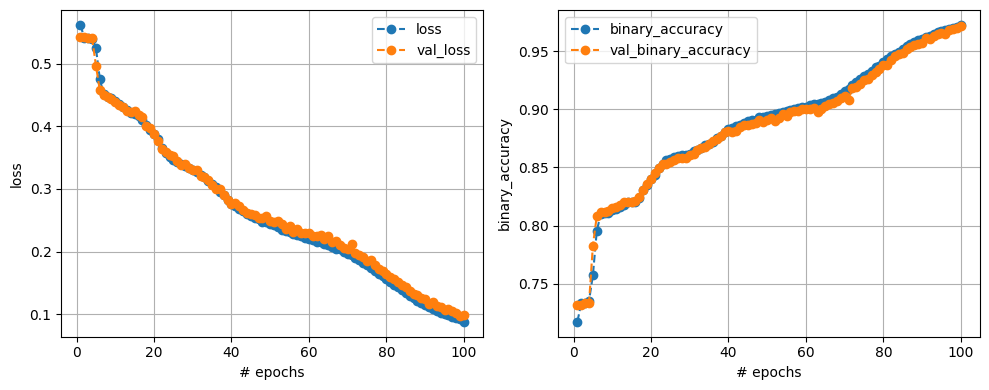

151/151 [==============================] - 1s 3ms/step - loss: 0.1004 - binary_accuracy: 0.9685
Loss en test: 0.1003793329000473
Accuracy en test: 0.9685212969779968


In [ ]:
# Usamos misma estructura que el modelo anterior
timer_gru = TimerCallback()
plotting_gru = PlotLearning()
early_stopping_gru = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_gru = ReduceLROnPlateau(patience=5, monitor='val_loss')

# Entrenamiento del modelo
history_gru = gru_model.fit(x_train, y_train, 
                              batch_size=256, 
                              epochs=100, 
                              validation_data=(x_val, y_val), 
                              callbacks=[timer_gru, plotting_gru, early_stopping_gru, reduce_lr_gru])

# Evaluación de modelo
loss_gru, acc_gru = gru_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_gru}")
print(f"Accuracy en test: {acc_gru}")

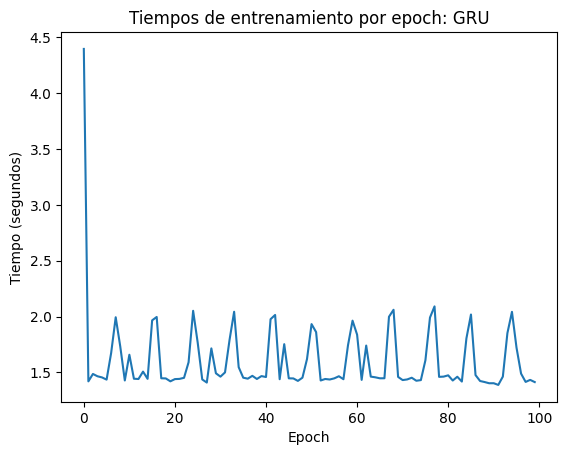

Tiempo total de entrenamiento: 160.92205776599963 segundos
Tiempo medio de epoch: 1.6092205776599962 segundos


In [ ]:
tiempo_entrenamiento("GRU", timer_gru)

In [ ]:
# Guardo el modelo y tiempos de epoch
gru_model.save(home+'modelo_gru.h5')
with open(home+'times_epoch_gru.pkl', 'wb') as f:
    pickle.dump(timer_gru.epoch_times, f)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
Los resultados indican que el modelo con una capa <b>GRU tiene un mejor rendimiento general</b> que el modelo con SimpleRNN, con una mejora significativa en la pérdida y la precisión en el conjunto de datos de prueba. GRU obtuvo una accuracy de 0.97 y una pérdida de 0.1. SimpleRNN una accuracy de 0.73 y una pérdida de 0.53.<br><br>
Debido al mayor número de epochs entrenados el model con una capa GRU tardó más, pero su época media dura 1.6s y la de SimpleRNN 11s. A esto también influye el número de parámetros que es menor en el modelo con GRU (13573) que el de SimpleRNN (17541).<br><br>
En general, se puede concluir que el modelo con capa GRU es mejor que el modelo con capa SimpleRNN en este problema. <b>La mejora se debe a que la estructura interna de la capa GRU es más compleja</b>, lo que le permite capturar patrones más complejos. A diferencia de la capa SimpleRNN, las capas GRU cuentan con dos puertas adicionales: la puerta de <i>reset</i> y la puerta de actualización. La puerta de reset permite seleccionar qué información va a ser utilizada en cada paso, mientras que la puerta de actualización ayuda a controlar que información se mantiene en memoria.
</div>

### 2.3.1 Incrementando la capacidad de nuestro modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>En esta sección intentaremos incrementar la capacidad de nuestro modelo y, para ello, en lugar de añadir unidades, aumentaremos la profundidad, sumando otra capa GRU. Esta nueva capa recibirá la sequencia de la capa anterior y tendrá la mitad de unidades.</p>
    <p>Comenta los resultados de rendimiento en <i>accuracy</i> y en tiempo.</p>
</div>

In [ ]:
# Modelo con 2 capas GRU
gru_model2 = Sequential([
    GRU(units=64, input_shape=(None,num_sensores), return_sequences=True),
    GRU(units=32),
    Dense(num_clases, activation='sigmoid')
])
gru_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
gru_model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 64)          13248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


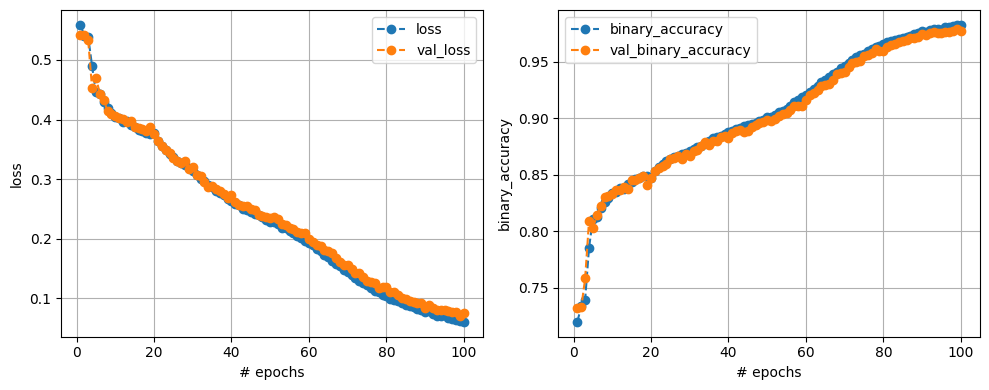

151/151 [==============================] - 1s 6ms/step - loss: 0.0763 - binary_accuracy: 0.9781
Loss en test: 0.07631577551364899
Accuracy en test: 0.9781147241592407


In [ ]:
# Utilizamos los mismos Callbacks
timer_gru2 = TimerCallback()
plotting_gru2 = PlotLearning()
early_stopping_gru2 = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_gru2 = ReduceLROnPlateau(patience=5, monitor='val_loss')

# Entrenamiento del modelo
history_gru2 = gru_model2.fit(x_train, y_train, 
                              batch_size=256, 
                              epochs=100, 
                              validation_data=(x_val, y_val), 
                              callbacks=[timer_gru2, plotting_gru2, early_stopping_gru2, reduce_lr_gru2])

# Evaluación de modelo
loss_gru2, acc_gru2 = gru_model2.evaluate(x_test, y_test)
print(f"Loss en test: {loss_gru2}")
print(f"Accuracy en test: {acc_gru2}")

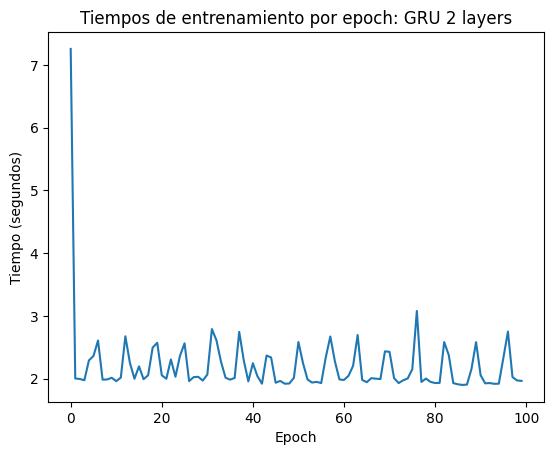

Tiempo total de entrenamiento: 219.84233065499757 segundos
Tiempo medio de epoch: 2.1984233065499756 segundos


In [ ]:
tiempo_entrenamiento("GRU 2 layers", timer_gru2)

In [ ]:
# Guardo el modelo y tiempos de epoch
gru_model2.save(home+'modelo_gru2.h5')
with open(home+'times_epoch_gru2.pkl', 'wb') as f:
    pickle.dump(timer_gru2.epoch_times, f)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
    <b>El modelo con dos capas GRU ha mostrado una ligera mejora en el rendimiento</b> en términos de accuracy en comparación con el modelo de una sola capa. Sin embargo, la complejidad del modelo se ha incrementado, ha habido un aumento tanto en el número de parámetros entrenables (casi el doble que en el modelo de una capa) como en el tiempo de entrenamiento (de 160s a 220s).<br><br>
En las gráficas de <i>accuracy</i> y <i>loss</i> del conjunto de datos de validación, observamos una evolución similar en ambos modelos. Dado que el tiempo de entrenamiento no es de larga duración, la mejora de añadir una capa GRU ha sido beneficiosa.
</div>

## 2.4 LSTM vs. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>   
Sabemos que otro tipo de capa utilizada para las series temporales son las LSTM. En esta sección probaremos esta arquitectura y la compararemos con la anterior, para ver si es posible mejorar en rendimiento (<code>accuracy</code>) y/o en el tiempo de entrenamiento. Para ello, utilizaremos las mismas unidades en 2 capas de LSTM y entrenaremos de la misma forma la red. </p>
</div>

In [ ]:
# Modelo con 2 capas LSTM
LSTM_model = Sequential([
    LSTM(units=64, input_shape=(None,num_sensores), return_sequences=True),
    LSTM(units=32),
    Dense(num_clases, activation='sigmoid')
])
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


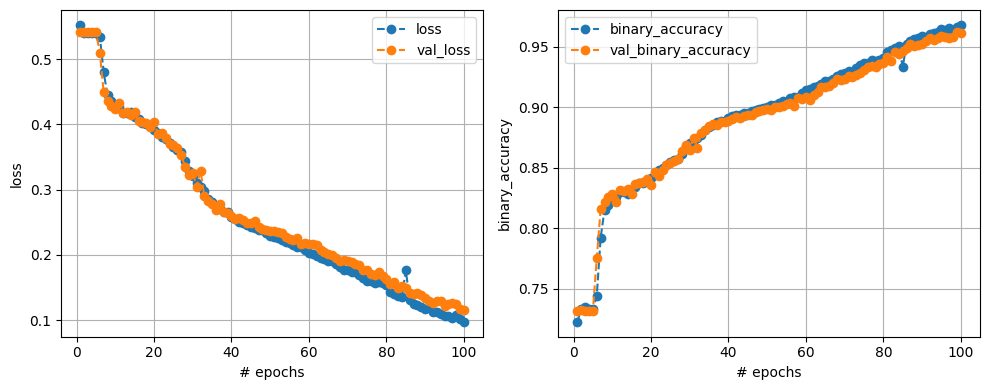

151/151 [==============================] - 1s 5ms/step - loss: 0.1125 - binary_accuracy: 0.9624
Loss en test: 0.11246170848608017
Accuracy en test: 0.962375283241272


In [ ]:
# Definición Callbacks
timer_lstm = TimerCallback()
plotting_lstm = PlotLearning()
early_stopping_lstm = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_lstm = ReduceLROnPlateau(patience=5, monitor='val_loss')

# Entrenamiento del modelo
history_lstm = LSTM_model.fit(x_train, y_train, 
                              batch_size=256, 
                              epochs=100, 
                              validation_data=(x_val, y_val), 
                              callbacks=[timer_lstm, plotting_lstm, early_stopping_lstm, reduce_lr_lstm])

# Evaluación de modelo
loss_lstm, acc_lstm = LSTM_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_lstm}")
print(f"Accuracy en test: {acc_lstm}")

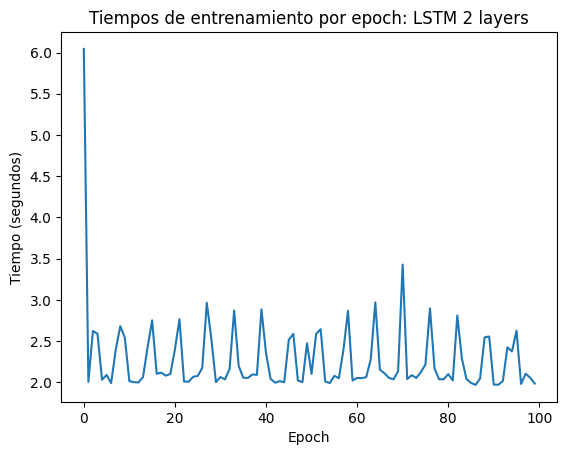

Tiempo total de entrenamiento: 227.66934403000005 segundos
Tiempo medio de epoch: 2.2766934403000003 segundos


In [ ]:
tiempo_entrenamiento("LSTM 2 layers", timer_lstm)

In [ ]:
# Guardo el modelo y tiempos de epoch
LSTM_model.save(home+'modelo_lstm.h5')
with open(home+'times_epoch_lstm.pkl', 'wb') as f:
    pickle.dump(timer_lstm.epoch_times, f)

# 3. Elección del mejor modelo y *fine tuning* (2 puntos)

En el apartado anterior ya hemos probado varios tipos de modelos diferentes. Ahora, basados en el rendimiento, complejidad (número de parámetros) y tiempo de entrenamiento, debemos escoger el tipo de modelo que mejor se adecua a nuestro problema. 

## 3.1 Comparación de modelos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]</strong>: Realiza y responde las siguientes cuestiones:</p>
  <ul>
    <li>Haz una tabla comparativa para todos los modelos y arquitecturas usadas comparando el rendimiento, el número de parámetros y el tiempo por época (time/epoch)</li>
    <li>Justifica la elección de un modelo</li>
  </ul>
</div>

In [ ]:
import pandas as pd

model_names = ['SimpleRNN', 'GRU (1 capa)', 'GRU (2 capas)', 'LSTM']
loss = [loss_rnn, loss_gru, loss_gru2, loss_lstm]
accuracy = [acc_rnn, acc_gru, acc_gru2, acc_lstm]
params = [simpleRNN_model.count_params(), gru_model.count_params(), gru_model2.count_params(), LSTM_model.count_params()]
time_per_epoch = [sum(timer_rnn.epoch_times)/len(timer_rnn.epoch_times), sum(timer_gru.epoch_times)/len(timer_gru.epoch_times), sum(timer_gru2.epoch_times)/len(timer_gru2.epoch_times), sum(timer_lstm.epoch_times)/len(timer_lstm.epoch_times)]
total_time = [sum(timer_rnn.epoch_times), sum(timer_gru.epoch_times), sum(timer_gru2.epoch_times), sum(timer_lstm.epoch_times)]

pd.DataFrame({
    'Modelo': model_names,
    'Loss': loss,
    'Accuracy': accuracy,
    'Parámetros': params,
    'Tiempo por época': time_per_epoch,
    'Tiempo total': total_time
})

,Modelo,Loss,Accuracy,Parámetros,Tiempo por época,Tiempo total
0,SimpleRNN,0.539386,0.731728,17541,11.041770,99.375928
1,GRU (1 capa),0.100379,0.968521,13573,1.609221,160.922058
2,GRU (2 capas),0.076316,0.978115,22821,2.198423,219.842331
3,LSTM,0.112462,0.962375,29989,2.276693,227.669344


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
En general, la elección del modelo se basa en las métricas de rendimiento (accuracy, loss), el tiempo de entrenamiento y la complejidad del modelo. En este caso, disponemos de tres modelos que presentan una precisión mayor al 96%.<br><br>
Sin embargo, observamos que el modelo con dos capas GRU obtiene una mejor precisión y una pérdida menor en comparación con los otros modelos. Este modelo tiene un tiempo de entrenamiento ligeramente mayor (60 segundos más) que el modelo con una sola capa GRU, pero es un tiempo insignificante.<br><br>
Por lo tanto, <b>elegimos el modelo con dos capas GRU</b>.
</div>

## 3.2 *Fine Tuning* de parámetros para el modelo elegido

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong>  Para realizar una elección de parámetros que optimize los resultados utilizaremos la librería <code>keras-tuner</code>. El primer paso con una librería nueva es consultar la documentación y familiarizarse con ejemplos básicos.</p>
<p>Los parámetros que eligiremos para el ajuste son:</p>
  <ul>
    <li><strong>Unidades de la primera capa</strong>. Variarán entre 16 y 64 con steps de 16.</li>
    <li>Añadiremos <strong>dropout en la segunda capa</strong> y los valores serán: 0, 0.1, 0.25 y 0.7 </li>
    <li><strong>Learning rate</strong> que podrá tomar los siguientes valores: 1e-2, 5e-3 y 1e-3</li>
  </ul>
<p>Finalmente, usaremos el método de <code>Hyperband</code> cuyo objetivo será optimizar la <i>accuracy</i> de validación.</p>
</div>

In [12]:
#------------------------------#
#    INSTALAMOS KERAS-TUNER    #
#------------------------------#

!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
# https://keras.io/keras_tuner/
def build_model(hp):
    
    model = Sequential()
    model.add(GRU(units=hp.Choice('units', values=[16, 32, 48, 64]), input_shape=(None,num_sensores), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout', values=[0.0, 0.1, 0.25, 0.7])))
    model.add(GRU(units=32))
    model.add(Dense(num_clases, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])),loss='binary_crossentropy',
                      metrics=['binary_accuracy'])
    return model

In [ ]:
# Optimizamos los parámetros usando Hyperband
tuner = kt.Hyperband(build_model, objective='val_loss')
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=0)

In [ ]:
# Mostramos los mejores parámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
best_hps.values

{'units': 32,
 'dropout': 0.25,
 'learning_rate': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 32)          3552      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 10,053
Trainable params: 10,053
Non-trainable params: 0
_________________________________________________________________


## 3.3 Entrenamiento del modelo con los hiperparámetros tuneados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>Tal como hicimos en la sección 2 con otro modelos, entrena el modelo final para la clasificación durante 100 epochs usando los parámetros obtenidos en el apartado anterior, <code>EarlyStoping</code> con una <i>patience</i> de 5 epochs, pero ahora sin el callback para reducir el <i>learning rate</i>.</p>
<p>Calcula el <i>accuracy</i> sobre el grupo de test y el tiempo total de entrenamiento.</p>
</div>

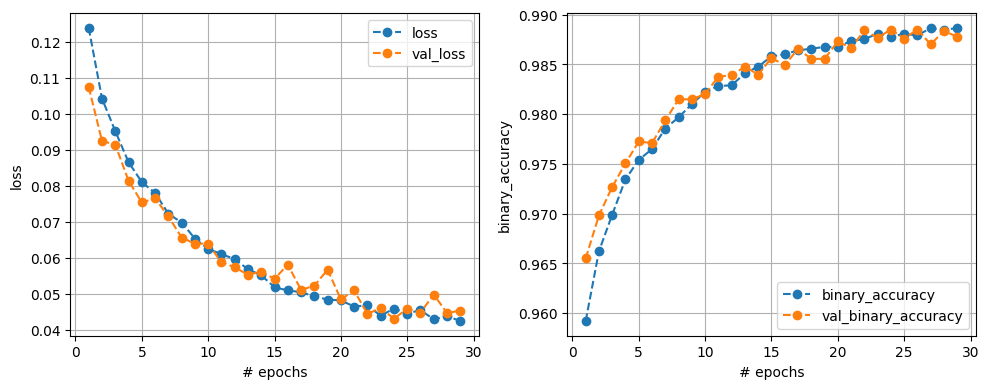

151/151 [==============================] - 1s 5ms/step - loss: 0.0435 - binary_accuracy: 0.9885
Loss en test: 0.04348599910736084
Accuracy en test: 0.988538384437561


In [ ]:
# Omitimos el callback ReduceLROnPlateau
timer_ft = TimerCallback()
plotting_ft = PlotLearning()
early_stopping_ft = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento FineTuned model
history_ft = best_model.fit(x_train, y_train,
                         batch_size=256, 
                         epochs=100,
                         validation_data=(x_val,y_val),
                         callbacks=[timer_ft, plotting_ft, early_stopping_ft])
# Evaluación de modelo
loss_ft, acc_ft = best_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_ft}")
print(f"Accuracy en test: {acc_ft}")

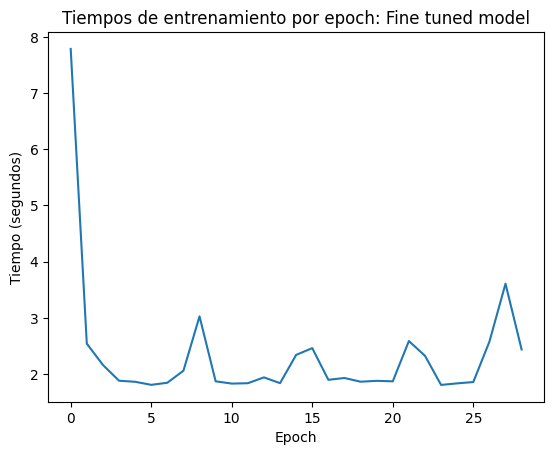

Tiempo total de entrenamiento: 67.52914729900044 segundos
Tiempo medio de epoch: 2.328591286172429 segundos


In [ ]:
tiempo_entrenamiento("Fine tuned model", timer_ft)

In [ ]:
# Guardo el modelo y tiempos de epoch
best_model.save(home+'modelo_ft.h5')
with open(home+'times_epoch_ft.pkl', 'wb') as f:
    pickle.dump(timer_ft.epoch_times, f)

In [14]:
# Carga del modelo por si cierre de sesión
from tensorflow import keras
best_model = keras.models.load_model(home+'modelo_ft.h5')

# 4. Localización de los errores (2 puntos)

## 4.1 Definiendo un nuevo modelo para la localización de los errores

Para encontrar cuándo ocurre un error en la lectura de un sensor, una secuencia determinada se dividirá en segmentos y la clasificación se realizará en cada segmento individualmente. Para ello, hay que definir un nuevo modelo que divida la señal de entrada y estas partes se le pasarán al siguiente _layer_ donde se usará el clasificador que ya hemos entrenado anteriormente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,5 pts.]:</strong>  Definir un nuevo modelo que constará de las siguientes capas (layers): </p>
  <ul>
    <li>  <code>Reshape</code> para cortar la entrada en sub-secuencias de 10 </li>
    <li>  Una capa con el clasificador anterior <code>best_model</code></li>
    <li>  Una capa final que nos permita obtener el máximo de las capas anteriores y poder comparar con los datos de entrenamiento</li>
  </ul>
<p> Entrena este modelo por 100 epochs usando, como siempre, EarlyStoping. Comenta los resultados y si realmente tiene sentido volver a entrenar con los mismos datos <code>x_train</code> de los que disponemos.</p>
</div>

In [ ]:
new_model = Sequential()
# Redimensionamos la entrada a 10 sub-secuencias. -1 indica que esa dimensión se calcula en base a los otros valores
new_model.add(Reshape(target_shape = (-1, 10, num_sensores), input_shape = (None, num_sensores)))
# TimeDistributed es un wrapper (encapsula) sobre el modelo previamente entrenado.
new_model.add(TimeDistributed(best_model))
# Tomamos el valor máximo reduciendo la dimensión de la muestra
new_model.add(GlobalMaxPool1D())

new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, None, 10, 3)       0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 5)          10053     
 tributed)                                                       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 5)                0         
 balMaxPooling1D)                                                
                                                                 
Total params: 10,053
Trainable params: 10,053
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evalúo el modelo antes de entrenar para entender mejor los resultados
loss_new_model, acc_new_model = new_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_new_model}")
print(f"Accuracy en test: {acc_new_model}")

151/151 [==============================] - 2s 3ms/step - loss: 1.1920 - binary_accuracy: 0.6360
Loss en test: 1.1920039653778076
Accuracy en test: 0.6359633803367615


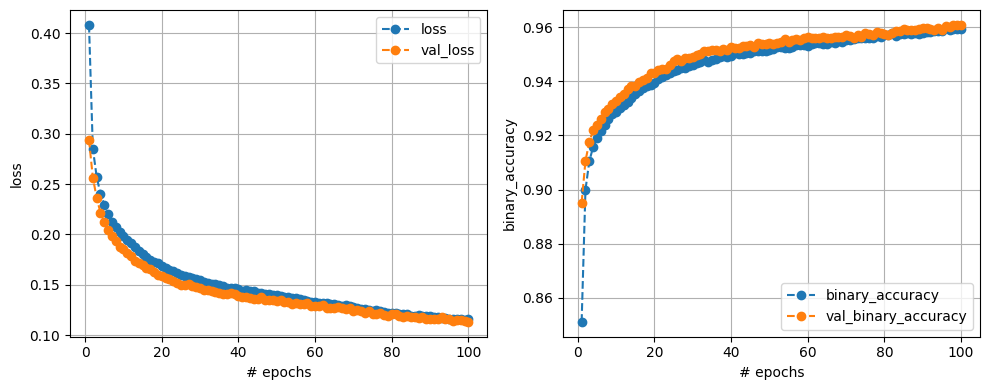

151/151 [==============================] - 0s 3ms/step - loss: 0.1126 - binary_accuracy: 0.9610
Loss en test: 0.11256501078605652
Accuracy en test: 0.9610465168952942


In [ ]:
timer_new_model = TimerCallback()
plotting_new_model = PlotLearning()
early_stopping_new_model = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history_new_model = new_model.fit(x_train, y_train, 
                              batch_size=256, 
                              epochs=100, 
                              validation_data=(x_val, y_val), 
                              callbacks=[timer_new_model, plotting_new_model, early_stopping_new_model])

# Evaluación de modelo
loss_new_model, acc_new_model = new_model.evaluate(x_test, y_test)
print(f"Loss en test: {loss_new_model}")
print(f"Accuracy en test: {acc_new_model}")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta, además, que efectos tiene en la localización el hecho de hacer un reshape para tener N=9 sub-secuencias. Si hubiéramos elegido N=2, 5 o 18, ¿qué cambiaría? </strong></p>
<br>
Es conveniente volver a entrenar, ya que <b>el modelo anterior tenía un tamaño de entrada mayor y por lo tanto más información</b>. Además, se ha observado que la evaluación del modelo nuevo antes del entrenamiento era significativamente peor que después del entrenamiento.<br><br>
Al realizar un reshape para tener 9 sub-secuencias de entrada, hemos dividido la lectura en divisiones de 10 datos y se ha obtenido una precisión del 96% en el conjunto de pruebas. Esta evaluación es buena debido a que en 10 pasos de lectura se puede determinar con gran confianza si ha habido un error o no. 
<br><br>
Si se usa una sub-secuencia distinta, los tamaño de entrada del modelo cambiará. Por ejemplo, si se establece <b>N=2, se necesitarán 45 datos como entrada, mientras que con N=5 se requerirán solo 18 y con N=18, solo 5</b>. Sin embargo, utilizar una sub-secuencia con N=18 puede dar peores resultados debido a que es posible que no haya suficientes datos para predecir los picos/errores de manera significativa.   
</div>

## 4.2 Modelo de localización de errores

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El modelo anterior devuelve predicciones para la secuencia completa, pero para poder localizar los errores necesitaremos las predicciones para cada sub-secuencia y, por lo tanto, definiremos un nuevo modelo, <code>loc_model</code>, igual al anterior, pero obviando el último layer.</p>
<p>Explica el resultado obtenido usando un dato de test como ejemplo.</p>
</div>

In [21]:
# Igual al modelo anterior sin la capa GlobalMaxPool1D
loc_model = Sequential()
loc_model.add(Reshape(target_shape = (-1, 10, num_sensores), input_shape = (None, num_sensores)))
loc_model.add(TimeDistributed(best_model))

loc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
loc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, None, 10, 3)       0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 5)          10053     
 tributed)                                                       
                                                                 
Total params: 10,053
Trainable params: 10,053
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Mostramos una predicción sobre un dato de test como ejemplo
# Cada fila es la predicción de los errores de una sub-secuencia de 10
prediccion = loc_model.predict(np.array([x_test[0]]), verbose=0)[0]
format=" "
for pos,i in enumerate(prediccion.tolist()):
    print(f"Sub-secuencia de {pos*10} a {pos*10 + 10}{format}", np.round(i))
    format="" # Para clarificar el print

Sub-secuencia de 0 a 10  [0. 0. 0. 0. 0.]
Sub-secuencia de 10 a 20 [1. 0. 0. 0. 0.]
Sub-secuencia de 20 a 30 [0. 0. 0. 0. 0.]
Sub-secuencia de 30 a 40 [0. 0. 0. 1. 0.]
Sub-secuencia de 40 a 50 [0. 0. 0. 0. 0.]
Sub-secuencia de 50 a 60 [0. 0. 0. 0. 0.]
Sub-secuencia de 60 a 70 [0. 1. 0. 0. 0.]
Sub-secuencia de 70 a 80 [0. 0. 0. 0. 0.]
Sub-secuencia de 80 a 90 [0. 0. 0. 0. 0.]


In [100]:
# Mostramos los errores reales sobre el dato de test ejemplo
errors = np.where(y_test[0] == 1)[0]
print(errors + 1)

[1 2 4]


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
Para simplificar llamaré lectura el dato de test de ejemplo.<br><br>
Se obtuvieron 9 predicciones para una lectura. Esto se debe a que <b>cada predicción es sobre una sub-secuencia de 10 datos y la longitud de la lectura se ajustó a 90 datos</b>.<br><br>
Cada predicción está compuestaa de 5 valores, los cuales representan la probabilidad de cada tipo de error en la sub-secuencia correspondiente. Por ejemplo, una predicción [0,0,0,1,0] indica un error tipo 4. La posición de la prediccón índica cuándo ha ocurrido el error en la lectura. Por ejemplo, la posición 4 indica la sub-secuencia 40 a 50 de datos.<br><br>
Al analizar el ejemplo de lectura en cuestión, se detectaron errores en las sub-secuencias 1, 3 y 6, con tipos de errores 1, 4 y 2, respectivamente. Como se puede comprobar en el segundo <i>print</i>, los errores efectivamente corresponden a las predicciones del modelo.    
</div>

## 5. Visualización de los errores  (1 punto)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Diseña una función que reciba una lectura de los sensores y su label, y que devuelva una gráfica con:</p>
    <ul>
    <li>  La lectura de los sensores.</li>
    <li>  Una banda vertical en la sub-secuencia donde se encuentra cada error. Habrá tantas bandas verticales como errores existan en la lectura.</li>
    <li>  Las bandas indicando errores deberán tener un color asociado a cada tipo de error y el <code>alpha</code> usado para pintar esa región será proporcional a la confianza en la clasificación de ese error.</li>
  </ul>
  <p>Además, informa de los errores detectados y los reales por pantalla. Usa esta función para visualizar 10 lecturas diferentes. ¿Qué color hace referencia al error producido por el paso del metro?</p>
</div>

In [92]:
# Puedes usar estos colores para cada identificar los diferentes tipos de errores
color_errores = {1: 'tab:red', 2: 'tab:purple', 3: 'tab:brown', 4: 'tab:cyan', 5: 'tab:olive'}

In [162]:
def plot_errors(lectura, label, model, ax):
        
    # Creamos la gráfica que muestre la lectura de los sensores
    plt.plot(lectura)
    
    # Realizamos la predicción de la lectura
    predictions = loc_model.predict(np.array([lectura]), verbose=0)[0]
    
    # Identificamos la sub-secuencia de cada error de las predicciones
    position, errors = np.where(np.round(predictions) == 1)

    # Añadimos las bandas verticales para cada predicción de error
    for pos, error in enumerate(errors):
        # Usamos alpha para visualizar la confianza de la clasificación
        # Para simplificar la visualización mostramos el error más probable
        # en cada sub-secuencia
        alpha = max(predictions[position[pos]])
        color = color_errores[error+1]
        plt.axvspan(position[pos]*10, (position[pos]*10)+10, color=color, alpha=alpha)
    
    # Agregamos una leyenda
    handles = []
    labels = []
    for key, value in color_errores.items():
        handles.append(plt.Rectangle((0, 0), 1, 1, color=value, alpha=0.5))
        labels.append(f"Error {key}")
    plt.legend(handles, labels, loc='upper right')
    
    # Mostramos en el título los errores reales
    real_errors = np.where(label == 1)[0]
    if len(real_errors) > 0:
        plt.title("Los errores reales son de tipo: "+str(real_errors + 1))
    else:
        plt.title("No hay errores reales")
    plt.yticks([])
    return plt
    

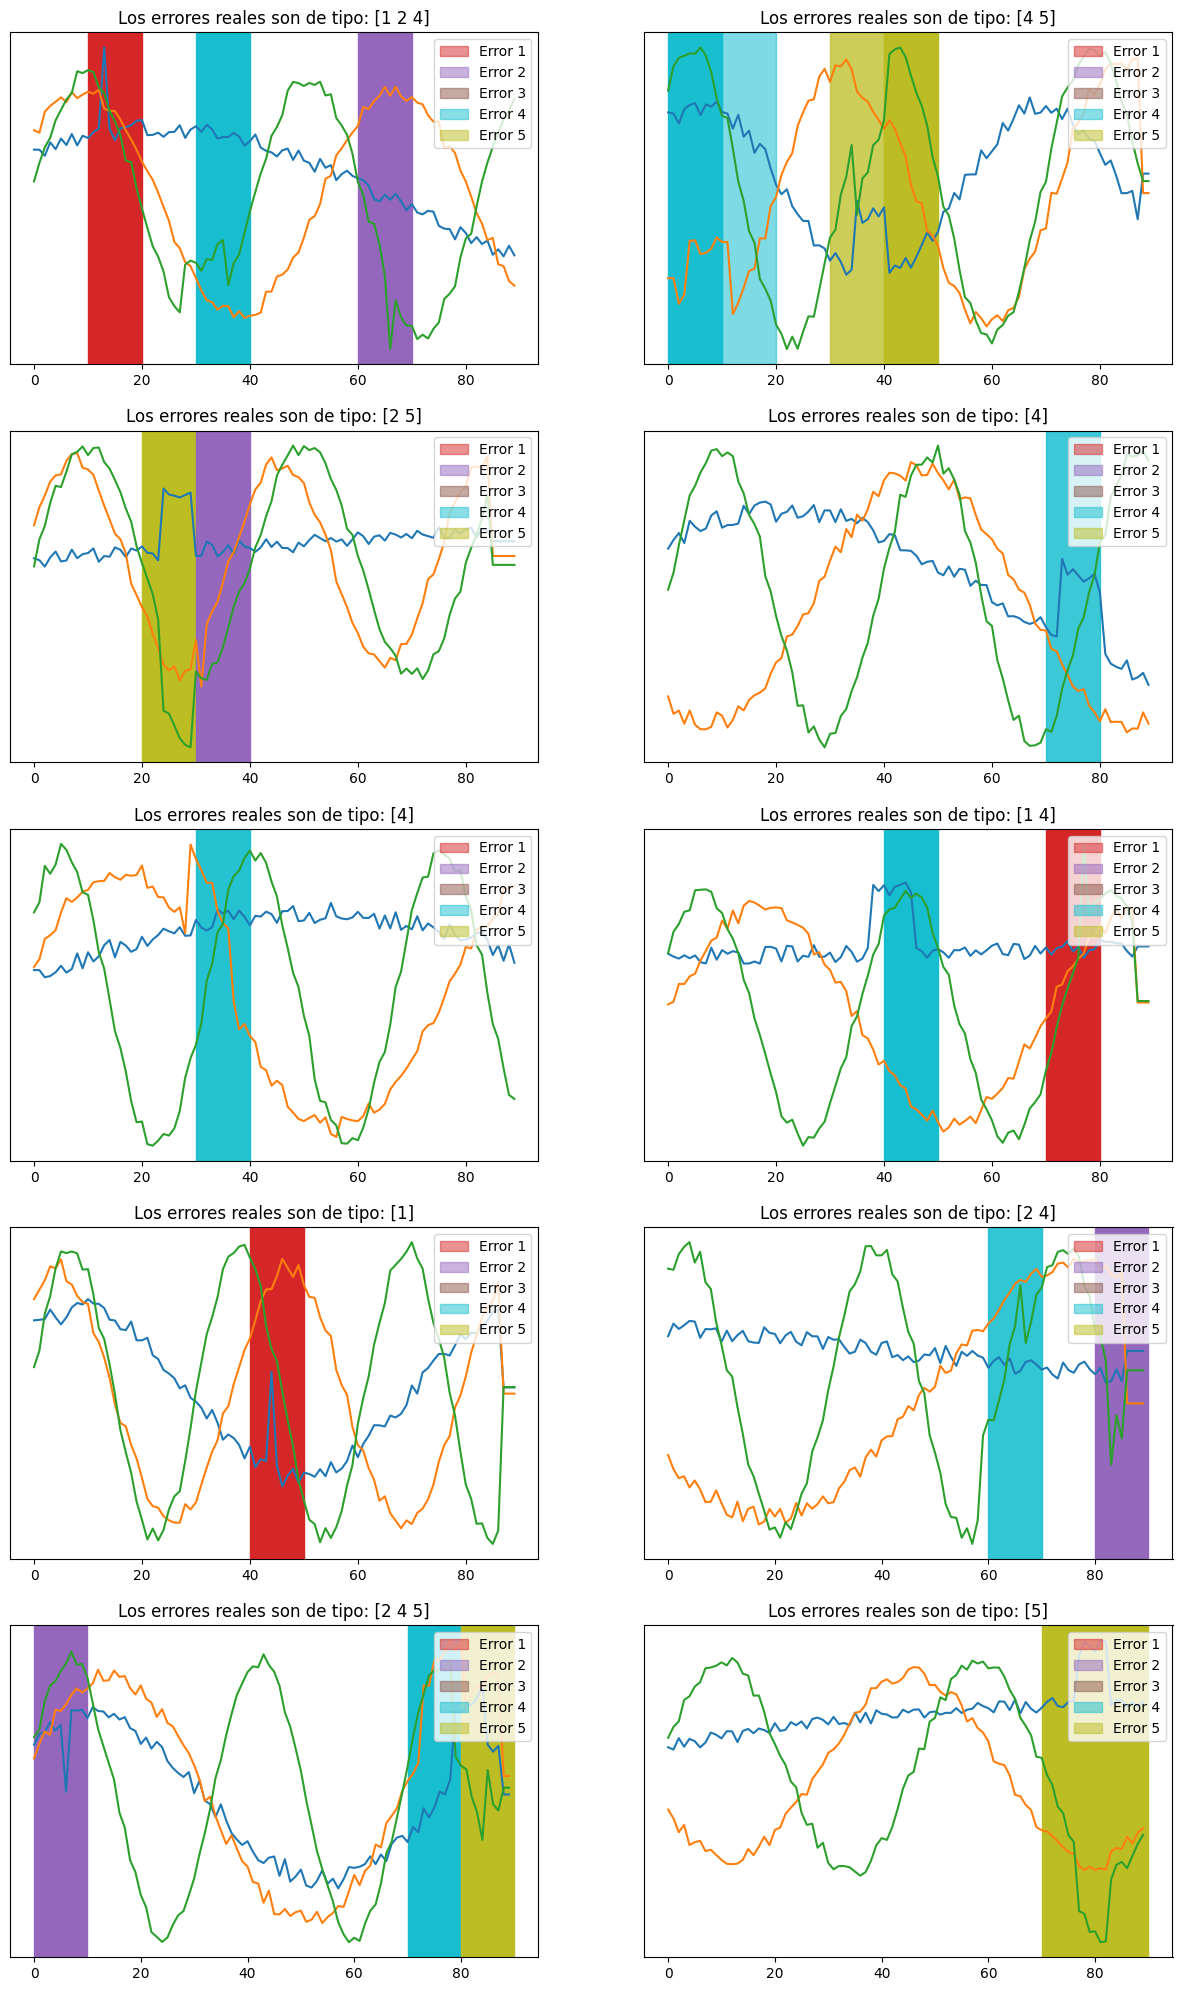

In [165]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

for i, ax in enumerate(axes.flatten()):
    plt.subplot(5,2,i+1)
    plot_errors(x_test[i], y_test[i], loc_model, ax=ax)
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>¿Qué color hace referencia al error producido por el paso del metro?</strong></p>
<br>
Según lo que se puede observar en la gráfica, hay un tipo de error que parece afectar los tres sensores al mismo tiempo. Es probable que este tipo de error esté relacionado con el paso del metro, ya que las vibraciones generadas afectarán las lecturas de los sensores por igual. <b>Este error es de tipo 5 y está representado por el color olive</b>.<br><br>    
En cuanto a los otros errores, se puede observar que generalmente afectan solo a un sensor a la vez. Esto sugiere que se trata de una lectura incorrecta producida por el propio sensor.    
</div>